In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

## Load Dataset

In [4]:
df = pd.read_csv('../data/processed_data_with_anomaly.csv')

## Definisi Fitur dan Target

In [5]:
features = ['Lag_1_Status', 'Count_Telat_7D', 'Count_Alpa_30D', 'Streak_Telat', 'Avg_Arrival_Time_7D', 'DayOfWeek']
le = LabelEncoder()

X = df[features]
# Encode 'Lag_1_Status' in the features
X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))

y = le.fit_transform(df['note'].astype(str))

/tmp/ipykernel_160656/870299856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))


## Split Data

In [6]:
# 80% train-test split

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Data Latih: {X_train.shape[0]} baris")
print(f"Data Uji: {X_test.shape[0]} baris")

Data Latih: 101904 baris
Data Uji: 25476 baris


## Class Weight

In [23]:
# For XGBoost & Naive Bayes
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
sample_weights

array([0.87478754, 0.59776507, 0.87478754, ..., 0.87478754, 0.87478754,
       0.87478754])

## Naive Bayes

In [24]:
nb_model = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', GaussianNB(var_smoothing=1e-09))
])

In [25]:
nb_model.fit(
    X_train, 
    y_train, 
    clf__sample_weight=sample_weights
)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', GaussianNB())])

## Decision Tree

In [26]:
dt_model = DecisionTreeClassifier(
    random_state=42,
    criterion='gini',
    max_depth=25,
    min_samples_leaf=10,
    min_samples_split=20,
    class_weight='balanced',
)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=25,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

## SVM

In [ ]:
svm_model = Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', SVC(
                random_state=42,
                C=1,
                gamma='scale',
                kernel='rbf',
                class_weight='balanced'
            ))
        ])

svm_model.fit(
    X_train,
    y_train,
)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=1, class_weight='balanced', random_state=42))])

## Random Forest

In [ ]:
rf_model = RandomForestClassifier(
  random_state=42,
  max_depth=7,
  max_features=3,
  min_samples_split=5,
  n_estimators=50,
  class_weight='balanced'
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=3,
                       min_samples_split=5, n_estimators=50, random_state=42)

## XGBoost

In [ ]:
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    colsample_bytree=0.5, 
    gamma=2, 
    learning_rate=0.2, 
    max_depth=3, 
    min_child_weight=0, 
    n_estimators=180, 
    reg_alpha=20, 
    reg_lambda=1, 
    seed=0
)
xgb_model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluation

In [30]:
models = {
    'Naive Bayes': nb_model,
    'Decision Tree': dt_model,
    'SVM': svm_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}


Evaluating Naive Bayes...

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.77      0.41      0.54     16819
           1       0.38      0.75      0.51      7735
           2       0.10      0.12      0.11       922

    accuracy                           0.51     25476
   macro avg       0.42      0.43      0.38     25476
weighted avg       0.63      0.51      0.51     25476


Confusion Matrix for Naive Bayes:


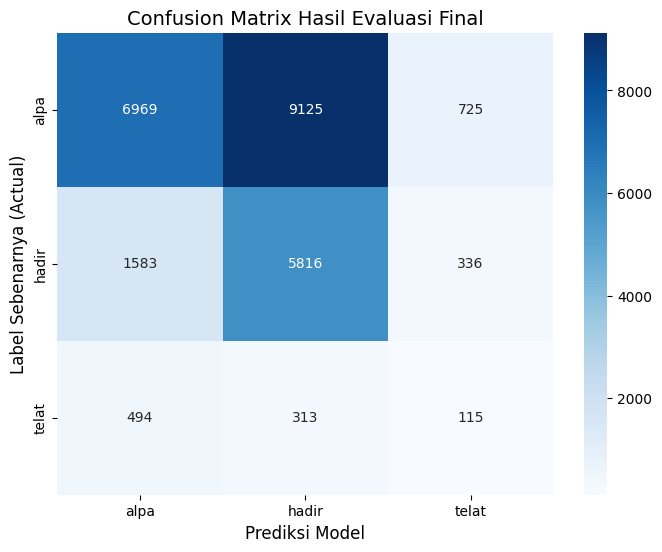


Evaluating Decision Tree...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.75      0.57      0.64     16819
           1       0.47      0.46      0.46      7735
           2       0.04      0.25      0.07       922

    accuracy                           0.52     25476
   macro avg       0.42      0.42      0.39     25476
weighted avg       0.64      0.52      0.57     25476


Confusion Matrix for Decision Tree:


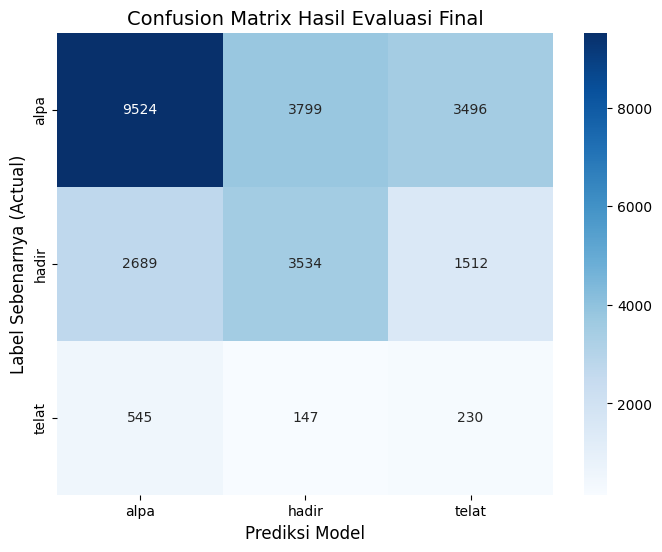


Evaluating SVM...

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.79      0.49      0.61     16819
           1       0.48      0.58      0.52      7735
           2       0.09      0.52      0.15       922

    accuracy                           0.52     25476
   macro avg       0.45      0.53      0.43     25476
weighted avg       0.67      0.52      0.56     25476


Confusion Matrix for SVM:


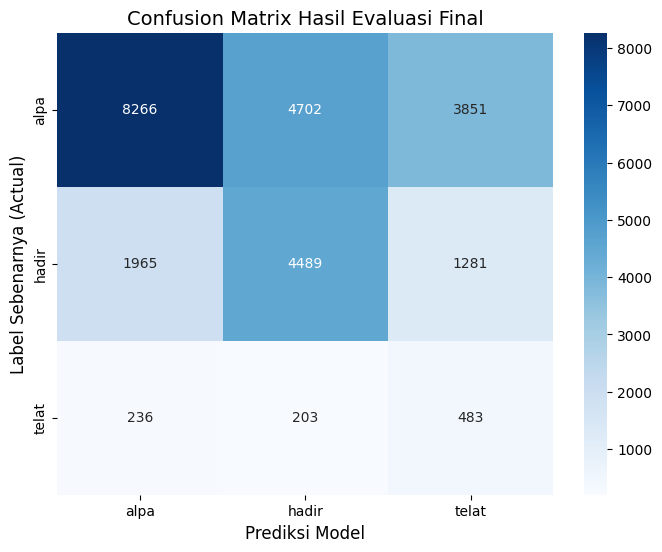


Evaluating Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.58      0.66     16819
           1       0.49      0.58      0.53      7735
           2       0.07      0.27      0.11       922

    accuracy                           0.57     25476
   macro avg       0.44      0.48      0.43     25476
weighted avg       0.66      0.57      0.60     25476


Confusion Matrix for Random Forest:


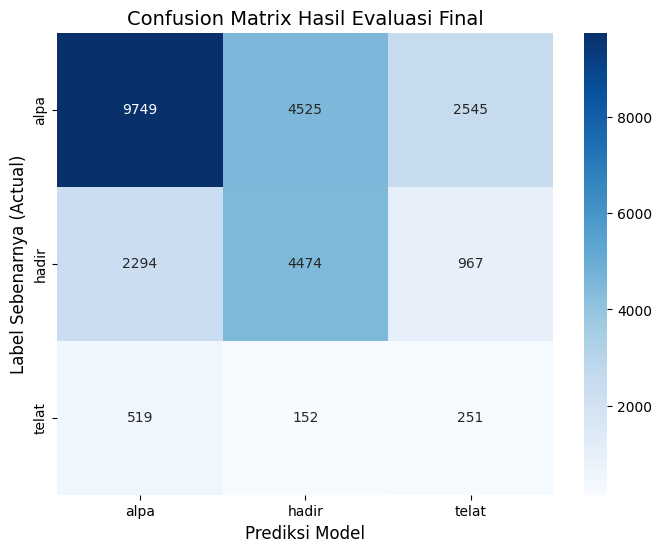


Evaluating XGBoost...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.76      0.50      0.61     16819
           1       0.49      0.58      0.53      7735
           2       0.06      0.36      0.11       922

    accuracy                           0.52     25476
   macro avg       0.44      0.48      0.42     25476
weighted avg       0.65      0.52      0.57     25476


Confusion Matrix for XGBoost:


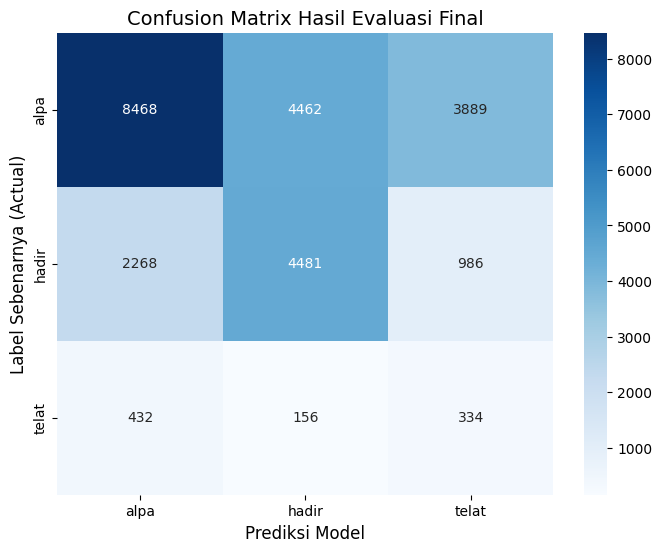

In [31]:
for name, model in models.items():
  print(f"\n{'='*50}")
  print(f"Evaluating {name}...")
  print('='*50)
  
  # Make predictions
  y_pred = model.predict(X_test)
  
  # Calculate metrics
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  
  # Store results
  results.append({
    'Model': name,
    'Recall (macro)': recall,
    'F1-Score (macro)': f1
  })
  
  # Print classification report
  print(f"\nClassification Report for {name}:")
  print(classification_report(y_test, y_pred))
  
  # Print confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  print(f"\nConfusion Matrix for {name}:")

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
              xticklabels=le.classes_, yticklabels=le.classes_)
  plt.xlabel('Prediksi Model', fontsize=12)
  plt.ylabel('Label Sebenarnya (Actual)', fontsize=12)
  plt.title('Confusion Matrix Hasil Evaluasi Final', fontsize=14)
  plt.show()

In [32]:
# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score (macro)', ascending=False)
print(f"\n{'='*50}")
print("MODEL COMPARISON SUMMARY")
print('='*50)
print(results_df.to_string(index=False))


MODEL COMPARISON SUMMARY
        Model  Recall (macro)  F1-Score (macro)
Random Forest        0.476762          0.433561
          SVM        0.531893          0.425931
      XGBoost        0.481683          0.415489
Decision Tree        0.424202          0.394410
  Naive Bayes        0.430330          0.384828


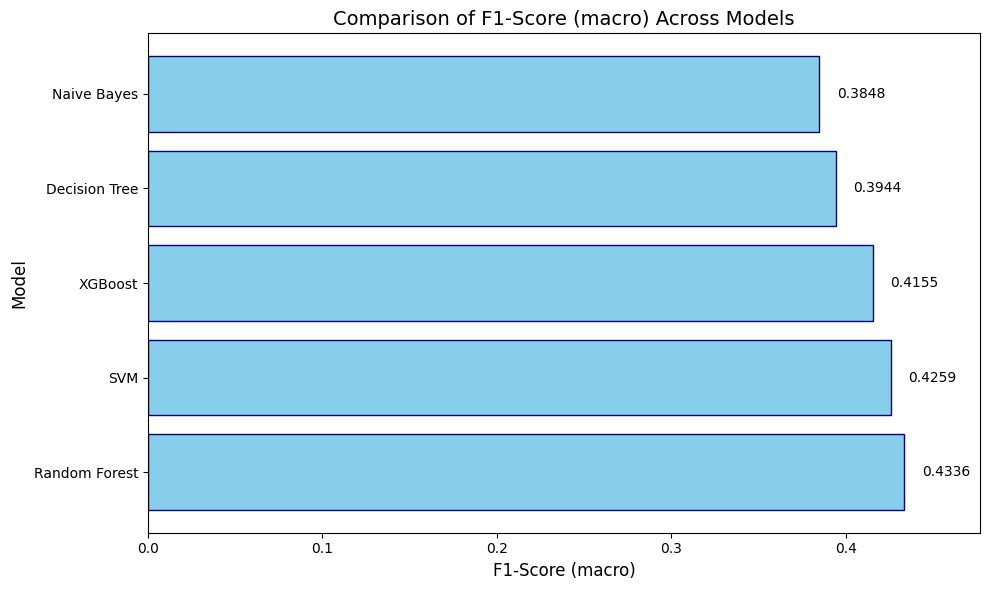

In [33]:
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['F1-Score (macro)'], color='skyblue', edgecolor='navy')
plt.xlabel('F1-Score (macro)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Comparison of F1-Score (macro) Across Models', fontsize=14)
plt.xlim(0, max(results_df['F1-Score (macro)']) * 1.1)

# Add value labels on bars
for i, (model, score) in enumerate(zip(results_df['Model'], results_df['F1-Score (macro)'])):
  plt.text(score + 0.01, i, f'{score:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()